In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy

# Ising model

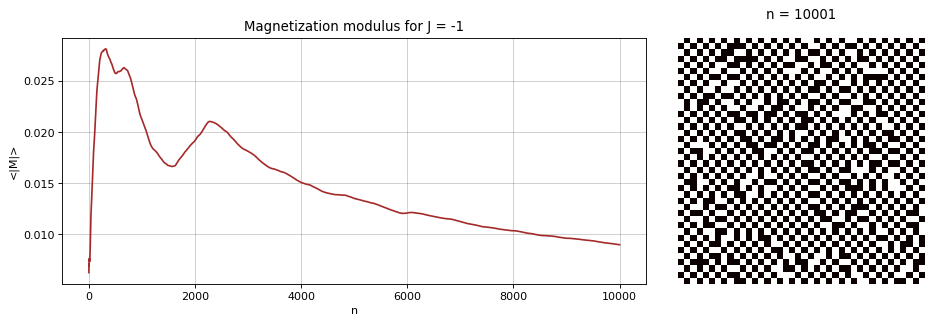

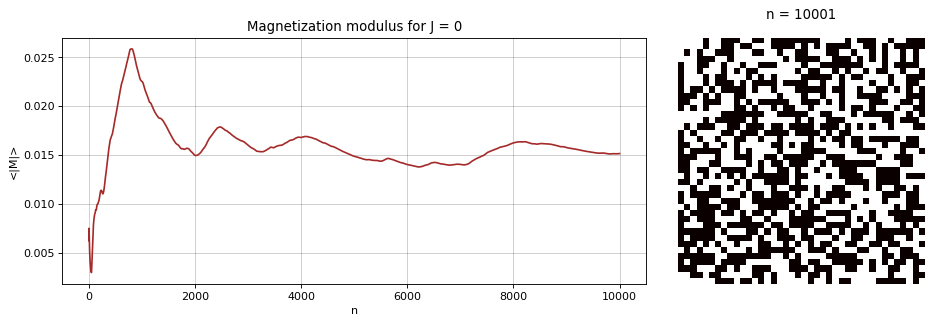

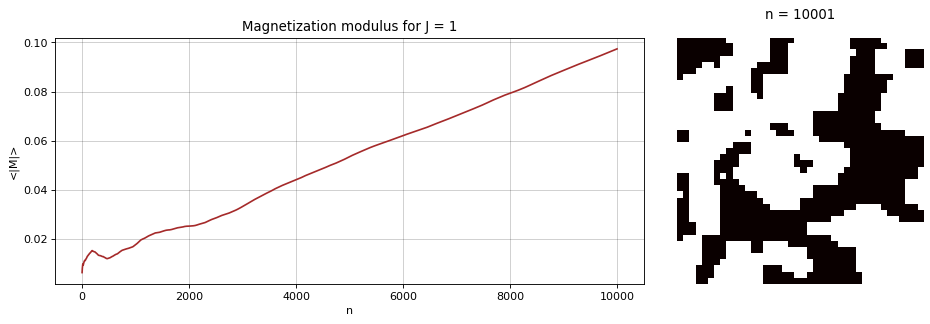

In [2]:
# Declare parameters
#---------------------------------------
n_steps = 10001
nx = 40
T = 1
k = 0.5

# Create initial grid
grid_0 = np.zeros((nx + 2, nx + 2))
grid_0[1:-1, 1:-1] = np.random.choice([-1, 1], (nx,nx))

def Ising_model(J):
    # Create grid
    grid = grid_0.copy()
    
    # Create list to store Magnetization modulus
    M = np.zeros(n_steps + 1)
    
    for step in range(n_steps):
        
        # Randomly choose lattice site 
        M[step:] += abs(np.sum(grid))
        i, j = np.random.randint(1,41, 2)

        # Hamiltonian
        H = J*(grid[i - 1, j] + grid[i + 1, j] + grid[i, j - 1] + grid[i, j + 1])
        
        # Probability
        P = np.exp(-H*2*grid[i, j])

        # Update grid
        if P > np.random.sample():
            grid[i, j] = -grid[i, j]

    # Create figures        
    fig = plt.figure(facecolor='w', figsize=(12,4), dpi=80)
 
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax.plot( M/(np.arange(1,n_steps+2)*(nx*nx)) , 'brown')
    ax.grid(b=True, which='major', c='k', alpha=0.2)
    ax.set_xlabel('n')
    ax.set_ylabel('<|M|>')
    ax.set_title('Magnetization modulus for J = %d' % J)
    
    ax = plt.subplot2grid((1, 3), (0, 2))
    ax.matshow(grid[1:-1, 1:-1], cmap = 'hot')
    ax.set_title('n = %i' % n_steps)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

for i in [-1, 0, 1]:
    Ising_model(i)

# Cellular-Potts model

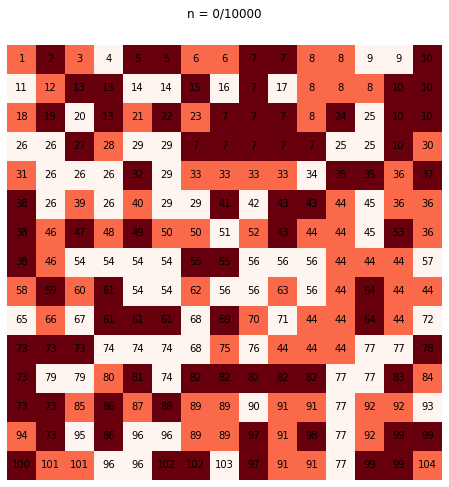

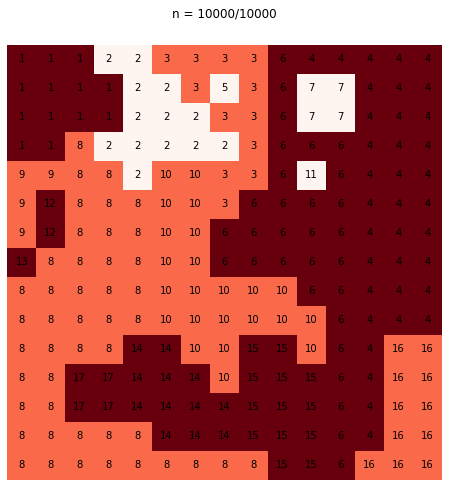

{'cell_counts': 17,
 'type_counts': {1: 4, 2: 5, 3: 8},
 'type_areas': {1: 18, 2: 97, 3: 110},
 'avg_areas': {1: 3.8, 2: 16.333333333333332, 3: 12.333333333333334}}

In [3]:
def visualize(grid1, grid2, n, N):
    """ A function to visualize the sigma and tau lattice in one image.
    Args:
        grid1: the tau lattice (shown as colours)
        grid2: the sigma lattice (shown as numbers)
        n: simulation step n
        N: max simulation steps
    """
    fig, ax = plt.subplots(figsize=(8,8))
    ax.matshow(grid1, cmap=plt.cm.Reds)
    for i in range(grid1.shape[0]):
        for j in range(grid1.shape[1]):
            cell_id = str(grid2[j,i])
            ax.text(i, j, cell_id, va='center', ha='center')
    plt.title(f'n = {n}/{N}')
    plt.axis('off')
    plt.show()
    
def inhabit(T):
    cells = {}
    ID = 1
    S = np.zeros_like(T, dtype=int)
    for i in range(1, T.shape[0]-1):
        for j in range(1, T.shape[1]-1):
            if cells == {}:
                S[i,j] = ID
                cells[ID] = [(i,j)]
            if T[i-1,j] == T[i,j]:
                cells[S[i-1,j]].append((i,j))
                S[i,j] = S[i-1,j]
            elif T[i,j-1] == T[i,j]:
                cells[S[i,j-1]].append((i,j))
                S[i,j] = S[i,j-1]
            elif T[i-1,j+1] == T[i,j] and T[i,j+1] == T[i,j]:
                cells[S[i-1,j+1]].append((i,j))
                S[i,j] = S[i-1,j+1]
            else:
                S[i,j] = ID
                cells[ID] = [(i,j)]
                ID += 1
    return S, cells

def rVN_n(i, j, size):
    """ This gives one random Von Neumann neighbour of the given indices
    """
    n = [(i-1,j),(i,j-1),(i+1,j),(i,j+1)]
    if i == 1:
        n.remove((i-1,j))
    elif i == size:
        n.remove((i+1,j))
    if j == 1:
        n.remove((i,j-1))
    elif j == size:
        n.remove((i,j+1))
    rn = np.random.randint(len(n))
    return n[rn]

def M_n(i, j):
    """ This gives the complete Moore neighbourhood of the given indices
    """
    return [(i-1,j-1),(i-1,j),(i-1,j+1),(i,j-1),(i,j+1),(i+1,j-1),(i+1,j),(i+1,j+1)]
            
def hamiltonian(T, S, cells, J, L, A_t):
    """ Computes the hamiltonian of the given lattice"""
    H_vol = L*sum([(len(cells[ID]) - A_t[T[cells[ID][0]]])**2 for ID in cells])
    H_bond = 0
    for i in range(1, T.shape[0]-1):
        for j in range(1, T.shape[1]-1):
            H_bond += sum([J[(T[i,j],T[i_,j_])] for (i_,j_) in M_n(i,j) if (S[i,j]!=S[i_,j_] and T[i_,j_]!=0)])
    return H_vol + H_bond

def CP_model(n_steps=10000, size=15, temp=1, L=1,
            J = {(1,1):0, (2,2):0, (3,3):0, (1,2):5, (2,1):5, (1,3):10, (3,1):10, (2,3):5, (3,2):5},
            A_t = {1:9, 2:12, 3:15}):
    """ This runs a full cellular potts simulation
    Arguments:
        n   - amount of simulation steps
        size  - size of 2D square-lattice
        temp   - temperature
        L   - cell stiffness (lambda parameter)
        J   - interaction strength between cell types
        A_t - target area for a cell
    """
    #N is the amount of cell types
    N = 3
    # Create lattice and inhabit with cells
    T = np.zeros((size + 2, size + 2))
    T[1:-1, 1:-1] = np.random.choice(list(range(1,N+1)), (size,size)) # cell types
    S, cells = inhabit(T) # cell IDs
    visualize(T[1:-1, 1:-1], S[1:-1, 1:-1], 0, n_steps)

    for n in range(1, n_steps+1):
        # Randomly choose lattice site 
        i, j = np.random.randint(1, size+1, 2)

        # Randomly choose Von Neumann neighbour
        i_trial, j_trial = rVN_n(i,j, size)
        if S[i,j] == S[i_trial,j_trial]:
            continue

        # Hamiltonian difference
        H_initial = hamiltonian(T, S, cells, J, L, A_t)
        T_trial = T
        T_trial[i,j] = T_trial[i_trial,j_trial]
        S_trial = S
        S_trial[i,j] = S_trial[i_trial,j_trial]
        H_trial = hamiltonian(T_trial, S_trial, cells, J, L, A_t)
        dH = H_trial - H_initial
           
        # Update grid bc lower energy or with probability P=exp(dH/temp)
        if dH <= 0 or np.exp(dH/temp) < np.random.sample():
            T = deepcopy(T_trial)
            S, cells = inhabit(T)
        
    # Create figures
    visualize(T[1:-1, 1:-1], S[1:-1, 1:-1], n, n_steps)
    
    # Compute metrics
    type_counts = {1:0,2:0,3:0}
    type_areas = {1:0,2:0,3:0}
    avg_areas = {}
    for cell in cells:
        type_counts[T[cells[cell][0]]] += 1
        type_areas[T[cells[cell][0]]] += len(cells[cell])
    for cell_type in type_areas:
        avg_areas[cell_type] = (type_areas[cell_type]+1)/(type_counts[cell_type]+1)
    return {'cell_counts':len(cells), 'type_counts':type_counts, 'type_areas':type_areas, 'avg_areas':avg_areas}

# base experiment
metrics = CP_model(n_steps=10000)
metrics

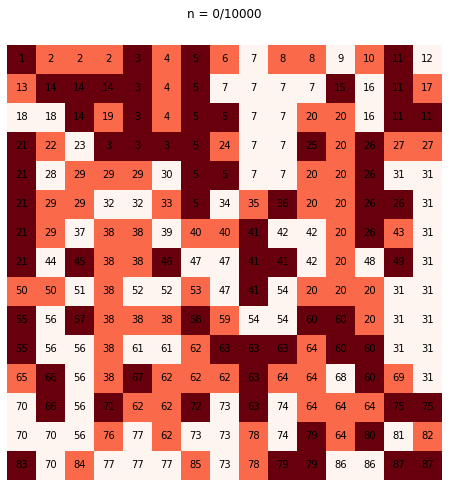

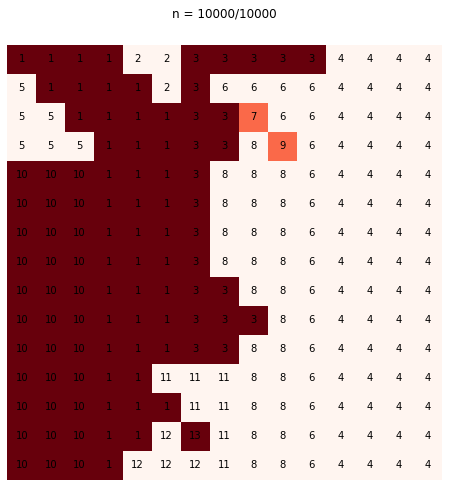

{'cell_counts': 13,
 'type_counts': {1: 7, 2: 2, 3: 4},
 'type_areas': {1: 124, 2: 2, 3: 99},
 'avg_areas': {1: 15.625, 2: 1.0, 3: 20.0}}

In [4]:
# Experiment 1: cell stiffness lambda

#stiffness
L1 = 20
#target areas
A_t1 = {1:9, 2:12, 3:15}

metrics1 = CP_model(n_steps=10000, L=L1, A_t=A_t1)
metrics1

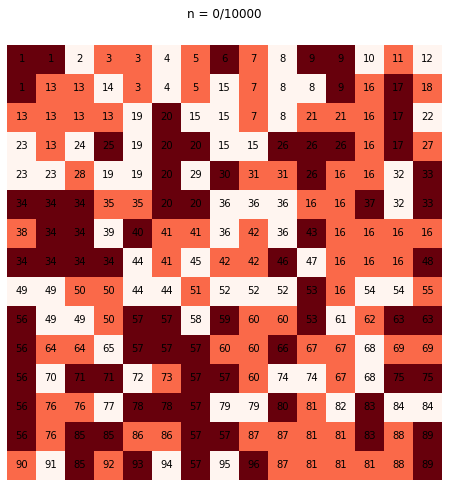

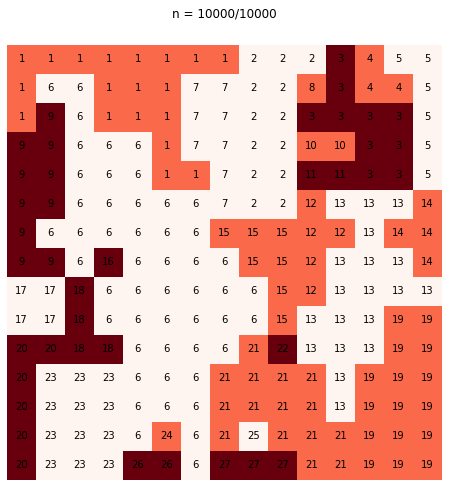

{'cell_counts': 27,
 'type_counts': {1: 8, 2: 10, 3: 9},
 'type_areas': {1: 113, 2: 73, 3: 39},
 'avg_areas': {1: 12.666666666666666, 2: 6.7272727272727275, 3: 4.0}}

In [5]:
# Experiment 2: Temperature

metrics2 = CP_model(n_steps=10000, temp=10)
metrics2

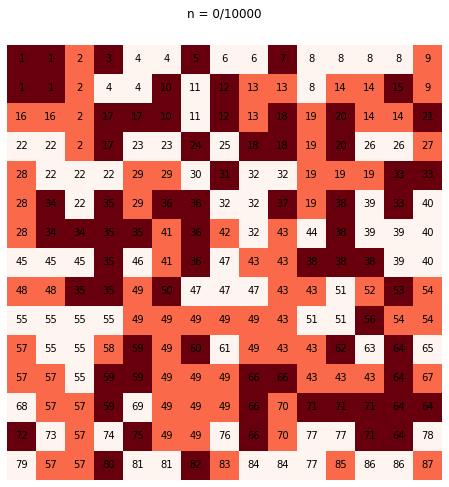

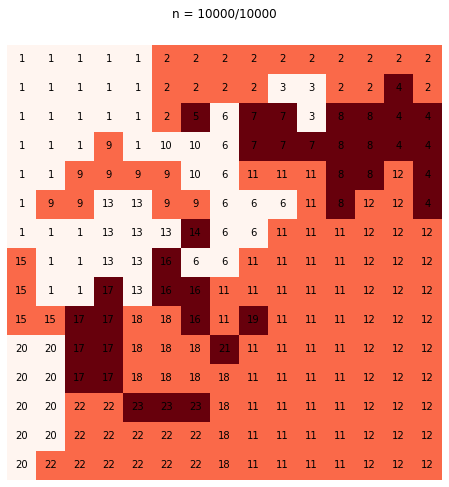

{'cell_counts': 23,
 'type_counts': {1: 6, 2: 7, 3: 10},
 'type_areas': {1: 61, 2: 127, 3: 37},
 'avg_areas': {1: 8.857142857142858, 2: 16.0, 3: 3.4545454545454546}}

In [6]:
# Experiment 3: Negative bond energy

#bonds
J1 = {(1,1):0, (2,2):0, (3,3):0, (1,2):5, (2,1):5, (1,3):10, (3,1):10, (2,3):-5, (3,2):-5}

metrics3 = CP_model(n_steps=10000, J=J1)
metrics3